### Playing around with the parameter C

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing
import random
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

#### Creation of data
We create 2 times 100 data points as follows:

In [2]:
def get_random_data(outlyer_pos=2):
    np.random.seed(1)
    X, y = make_classification(n_samples=100, 
                           n_features=2, 
                           n_redundant=0, 
                           n_informative=2,
                           random_state=1, 
                           n_clusters_per_class=1, 
                           class_sep=1.31)
    X += 2.2 * np.random.uniform(size=X.shape) #Make them overlapp
    n = np.shape(X)[0] # number of data points
    y[y==0] = -1
    return preprocessing.scale(X),y

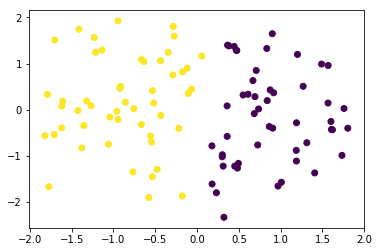

In [3]:
X,y = get_random_data()
plt.scatter(X[:,0],X[:,1],c=y)
#plt.show()

#### The meaning of the parameter C

To get an idea about the meaning of the parameter C we look at the number of support vectors. The support vectors either lie on the wrong side or in the margin. So many support vectors indicate a large margin.

In [4]:
for C in (1e-3, 1e-2, 1e-1, 1, 1e1,1e2,1e10):
    svc = svm.SVC(kernel='linear', C=C).fit(X,y)
    print('C={0} number of SV={1}'.format(C, len(svc.support_vectors_)))

C=0.001 number of SV=100
C=0.01 number of SV=86
C=0.1 number of SV=43
C=1 number of SV=15
C=10.0 number of SV=5
C=100.0 number of SV=3
C=10000000000.0 number of SV=3


The larger the value C is the less SV. Hence with a rising C the margin gets smaller. This is consistent with  Elements of statistical learning and the slides. 

```
The margin is larger for C = 0.01 than it is for C = 10, 000. p421
```

Further the dual form in http://scikit-learn.org/stable/modules/svm.html#svc and Eq. 12.13 in Elements of statistical learning look the same.

### Introducation to statistical learning
The parameter C in the ISLR is different. They always try to maximize the margin M under the constrain $\sum \beta^2 = 1$ and do not set the margin width to 1 and then minimize $\beta$.

In the R example they also talk about a parameter `cost` which is same as the C above.


## Animation

In [5]:
# Plots the data and predictions
# Code taken from: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
def plot_preds(clf, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    ## plotting the prediction 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.clf()
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)    
    
    w = clf.coef_[0]
    a = -w[0] / w[1]
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    x_m = np.linspace(-5, 5)
    y_m = a * x_m - (clf.intercept_[0]) / w[1]
    yy_down = y_m + a * margin
    yy_up = y_m - a * margin

    plt.plot(x_m, y_m, 'k-')
    plt.plot(x_m, yy_down, 'k--')
    plt.plot(x_m, yy_up, 'k--')
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.title("Num SV {}".format(len(clf.support_vectors_)))

In [6]:
from ipywidgets import *

def plot_func(C):
    clf = svm.SVC(kernel='linear', C=C)
    clf.fit(X=X, y=y)
    plot_preds(clf, X, y)

interact(plot_func, 
         C=(0.1,150,0.5)
         #out=FloatSlider(value=1, min=-3, max=3, step=0.5)
        )

interactive(children=(FloatSlider(value=74.6, description='C', max=150.0, min=0.1, step=0.5), Output()), _dom_…

<function __main__.plot_func(C)>

### Going into detail: Fitting a Support Vector Machine

We fit the the SVM and look into details

In [7]:
C = 10000000000.0
svc = svm.SVC(kernel='linear', C=C, probability=True).fit(X,y)

$$f(x) = \sum_{i=0}^N \alpha_i y_i k(x_i,x) + b$$

In [8]:
svc.support_vectors_

array([[ 0.17811277, -0.78366386],
       [-0.17637016, -1.86705896],
       [ 0.05814363,  1.16289231]])

In [9]:
print(svc.dual_coef_)     #This is alpha*y_i
print(svc.intercept_)     #This is b

[[-27.45714668  17.45083386  10.00631282]]
[0.76431344]


In [10]:
def getDecission(sv, yalphas, b, x):
    summ = 0
    for i in range(np.shape(sv)[0]):
        summ += yalphas[0,i] * (np.dot(sv[i],x))
    return summ + b

In [11]:
for x in np.linspace(-2,2,15):
    print(x, getDecission(svc.support_vectors_, svc.dual_coef_, svc.intercept_, np.asarray([0,x]))
          ,svc.predict(np.asarray([[0,x]])))

-2.0 [-0.37909026] [-1]
-1.7142857142857144 [-0.21574688] [-1]
-1.4285714285714286 [-0.05240349] [-1]
-1.1428571428571428 [0.1109399] [1]
-0.8571428571428572 [0.27428328] [1]
-0.5714285714285716 [0.43762667] [1]
-0.2857142857142858 [0.60097005] [1]
0.0 [0.76431344] [1]
0.2857142857142856 [0.92765683] [1]
0.5714285714285712 [1.09100021] [1]
0.8571428571428568 [1.2543436] [1]
1.1428571428571428 [1.41768698] [1]
1.4285714285714284 [1.58103037] [1]
1.714285714285714 [1.74437375] [1]
2.0 [1.90771714] [1]
